In [2]:
import sys

sys.path.append("..")
import BuildHiddenWeights as bhw  # builders
import HiddenWeightHelpers as hw  # plots, stats, norms, saving, open-loop
import os
import numpy as np
import torch

/home/mwagner/bin/anaconda3/envs/hcprediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CLEAN (base) MATRIX


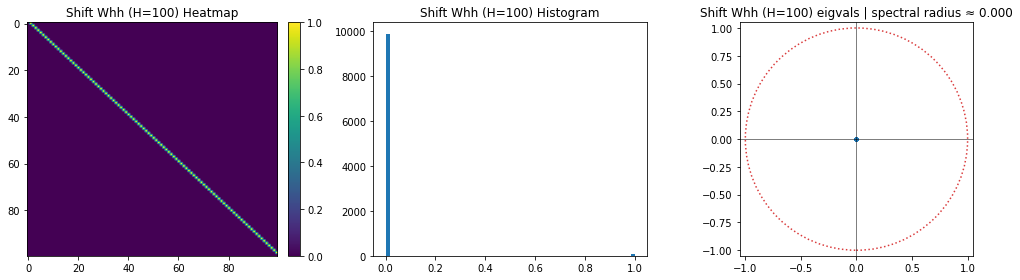

[Shift (clean) — symmetric] var=0.00485199  σ_max=0.9995  ρ=0.9995  asym=0.0000  mean=9.900e-03
[Shift (clean) — skew] var=0.00495  σ_max=0.9995  ρ=0.9995  asym=2.0000  mean=0.000e+00


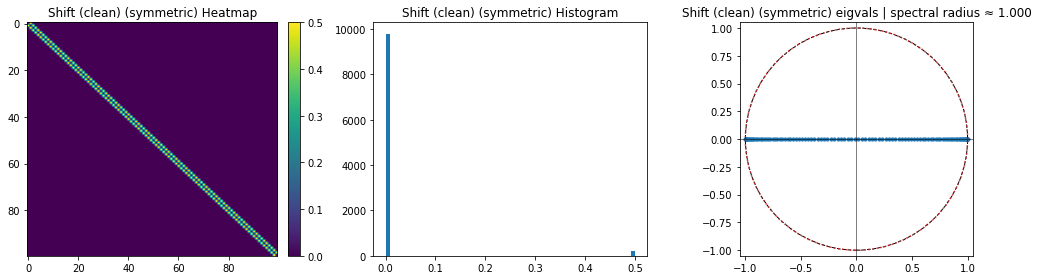

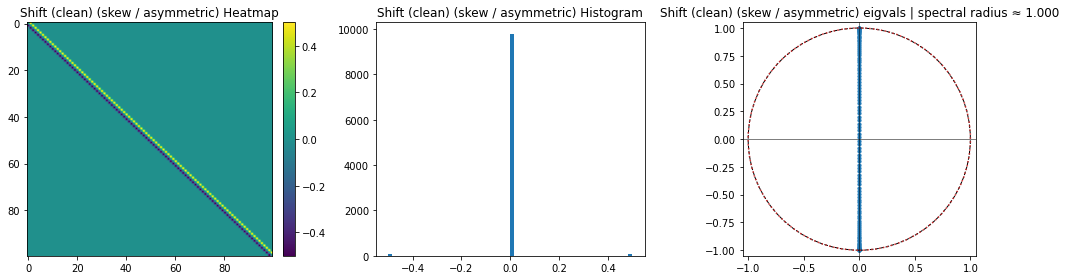


=== noise eps=0.0 mode=offdiag ===
noise info: {'mode': 'offdiag', 'noise_std': 0.0, 'effective_entry_std': 0.0, 'scale_by_sqrtN': True}
spectral normalization: {'scale': 0.9, 'sigma_before': 1.0, 'sigma_after': 0.8999999761581421, 'status': 'ok'}
[Shift+noise (eps0e+00_modeoffdiag_siggain0p90)] var=0.00793961  σ_max=0.9000  ρ=0.0000  asym=1.4142  mean=8.910e-03  |  gain_err=2.384e-08 (rel 0.00%)


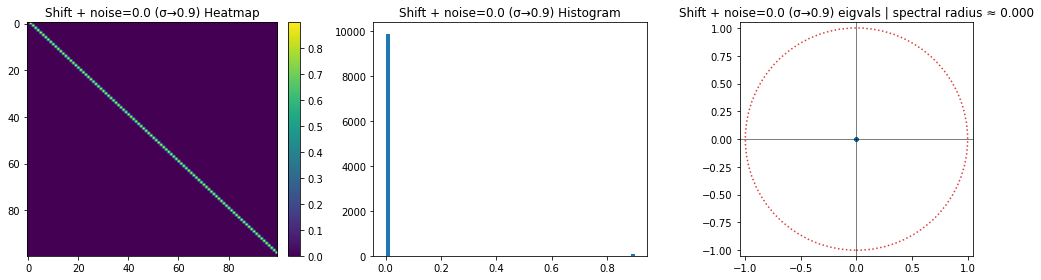

[Shift + noise=0.0 (σ→0.9) — symmetric] var=0.00393011  σ_max=0.8996  ρ=0.8996  asym=0.0000  mean=8.910e-03
[Shift + noise=0.0 (σ→0.9) — skew] var=0.0040095  σ_max=0.8996  ρ=0.8996  asym=2.0000  mean=0.000e+00


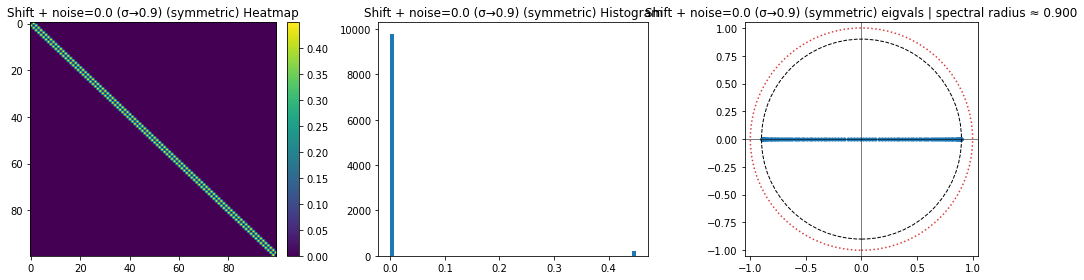

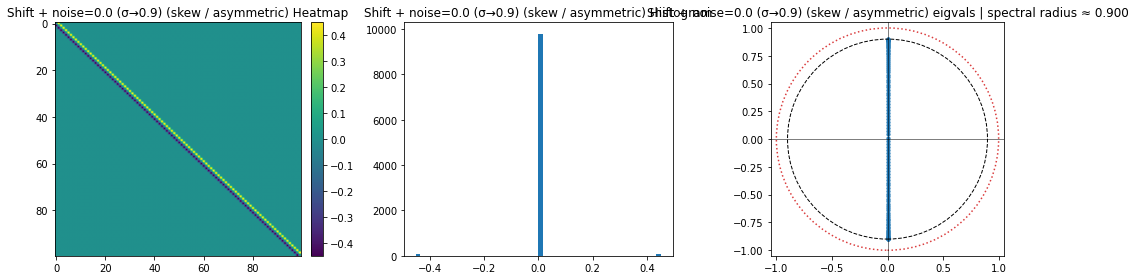


=== noise eps=0.001 mode=offdiag ===
noise info: {'mode': 'offdiag', 'noise_std': 0.001, 'effective_entry_std': 0.0001, 'scale_by_sqrtN': True}
spectral normalization: {'scale': 0.898740269173986, 'sigma_before': 1.001401662826538, 'sigma_after': 0.9000000953674316, 'status': 'ok'}
[Shift+noise (eps1e-03_modeoffdiag_siggain0p90)] var=0.00791758  σ_max=0.9000  ρ=0.8434  asym=1.4142  mean=8.898e-03  |  gain_err=9.537e-08 (rel 0.00%)


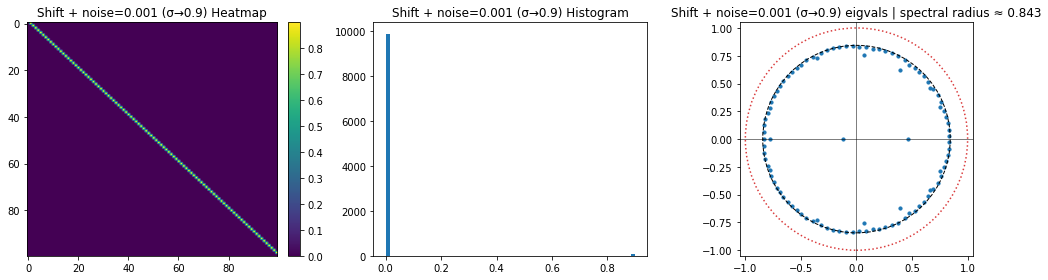

[Shift + noise=0.001 (σ→0.9) — symmetric] var=0.00391909  σ_max=0.8984  ρ=0.8984  asym=0.0000  mean=8.898e-03
[Shift + noise=0.001 (σ→0.9) — skew] var=0.00399849  σ_max=0.8984  ρ=0.8984  asym=2.0000  mean=5.662e-11


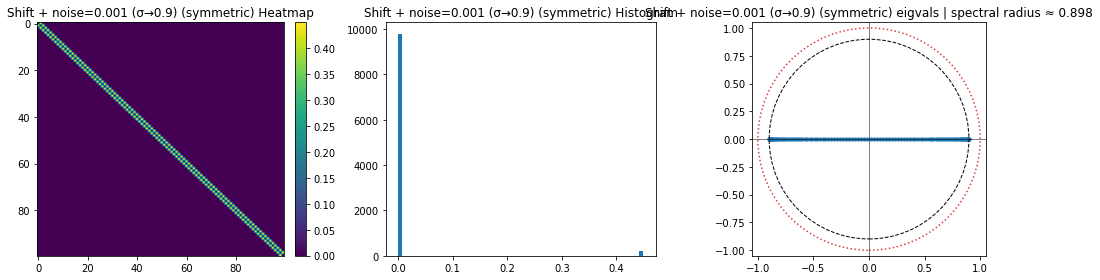

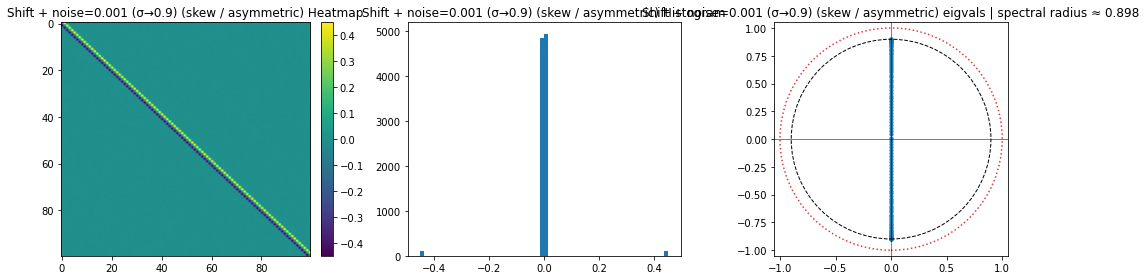


=== noise eps=0.005 mode=offdiag ===
noise info: {'mode': 'offdiag', 'noise_std': 0.005, 'effective_entry_std': 0.0005, 'scale_by_sqrtN': True}
spectral normalization: {'scale': 0.8937320766684436, 'sigma_before': 1.007013201713562, 'sigma_after': 0.8999999761581421, 'status': 'ok'}
[Shift+noise (eps5e-03_modeoffdiag_siggain0p90)] var=0.00783044  σ_max=0.9000  ρ=0.8549  asym=1.4143  mean=8.851e-03  |  gain_err=2.384e-08 (rel 0.00%)


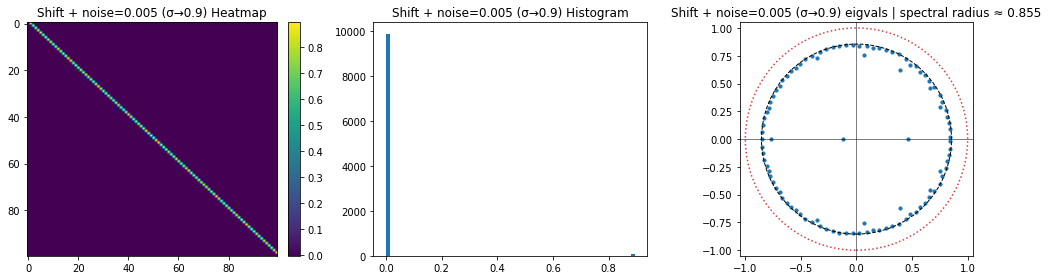

[Shift + noise=0.005 (σ→0.9) — symmetric] var=0.0038755  σ_max=0.8938  ρ=0.8938  asym=0.0000  mean=8.851e-03
[Shift + noise=0.005 (σ→0.9) — skew] var=0.00395494  σ_max=0.8937  ρ=0.8937  asym=2.0000  mean=-3.576e-11


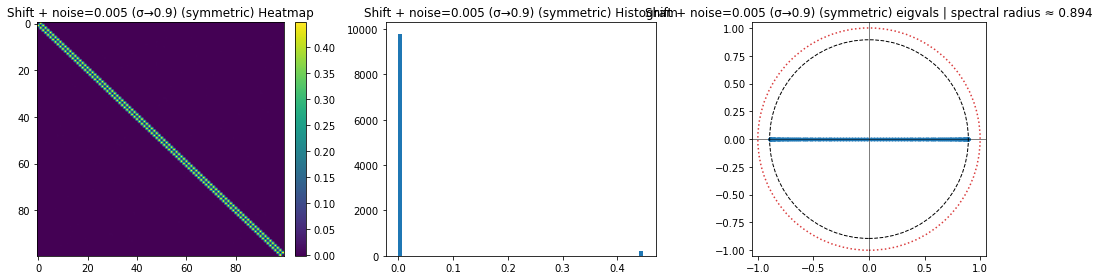

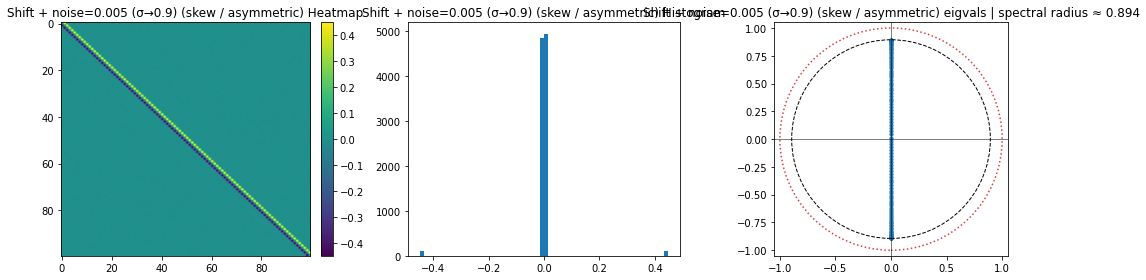


=== noise eps=0.01 mode=offdiag ===
noise info: {'mode': 'offdiag', 'noise_std': 0.01, 'effective_entry_std': 0.001, 'scale_by_sqrtN': True}
spectral normalization: {'scale': 0.8875407327240877, 'sigma_before': 1.0140379667282104, 'sigma_after': 0.8999999761581421, 'status': 'ok'}
[Shift+noise (eps1e-02_modeoffdiag_siggain0p90)] var=0.00772373  σ_max=0.9000  ρ=0.8565  asym=1.4144  mean=8.793e-03  |  gain_err=2.384e-08 (rel 0.00%)


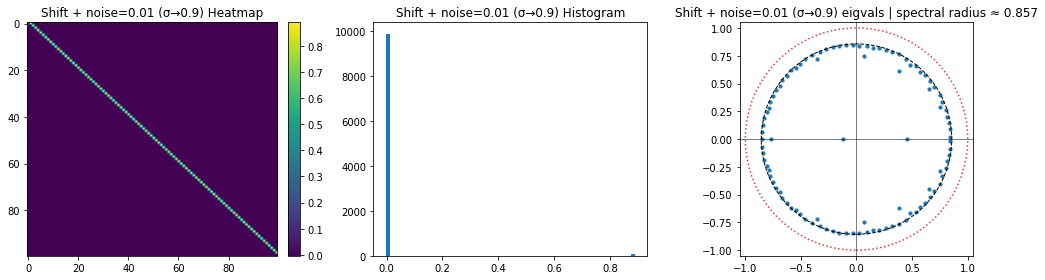

[Shift + noise=0.01 (σ→0.9) — symmetric] var=0.00382212  σ_max=0.8884  ρ=0.8884  asym=0.0000  mean=8.793e-03
[Shift + noise=0.01 (σ→0.9) — skew] var=0.00390161  σ_max=0.8880  ρ=0.8880  asym=2.0000  mean=1.192e-11


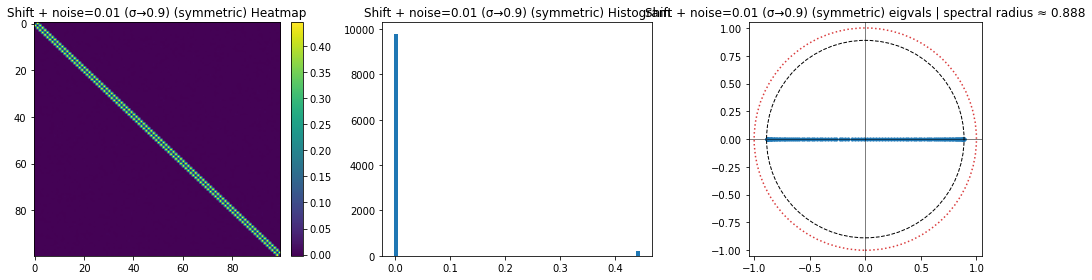

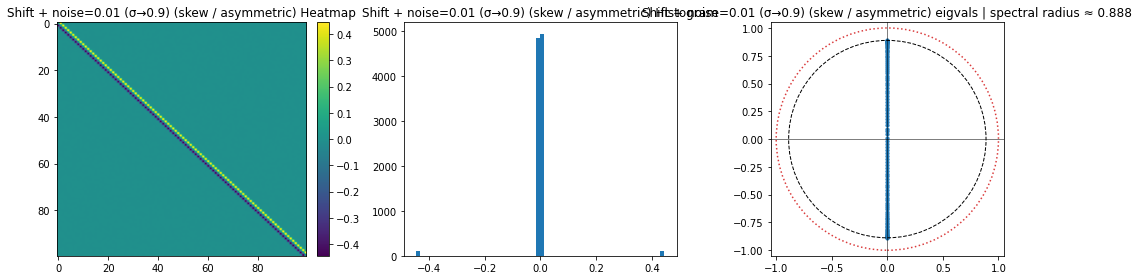

In [3]:
# --- build clean shift matrix ---
hidden_n = 100
W_clean = bhw.build_shift(n=hidden_n, value=1.0, offset=1, cyclic=False)

print("CLEAN (base) MATRIX")
hw.plot_weight_all(W_clean, title=f"Shift Whh (H={hidden_n})")
hw.plot_sym_asym(W_clean, base_title="Shift (clean)")

# Optional: show default Wxh/Why too, if you want:
# H.plot_weight_all(W_xh, title=f"Default Wxh (H={hidden_n})")
# H.plot_weight_all(W_hy, title=f"Default Why (H={hidden_n})")

# --- experiment settings ---
noise_levels = [0.0, 1e-3, 5e-3, 1e-2]  # tiny → small noise
noise_mode = "offdiag"  # try "all" or "support_only" too
target_sigma = 0.90  # keep σ_max equal across variants
seed = 0

save_root = "../data/Ns100_SeqN100/hidden-weight-inits/shift"
os.makedirs(save_root, exist_ok=True)

for eps in noise_levels:
    # (1) add noise
    W_noisy, ninfo = hw.add_gaussian_noise_np(
        W_clean, noise_std=eps, seed=seed, mode=noise_mode, scale_by_sqrtN=True
    )
    print(f"\n=== noise eps={eps} mode={noise_mode} ===")
    print("noise info:", ninfo)

    # (2) re-normalize to compare apples-to-apples (data-free option)
    W_norm, nfo = hw.normalize_by_spectral(W_noisy, target_sigma=target_sigma)
    print("spectral normalization:", nfo)

    # (3) summaries & plots
    tag = f"eps{eps:.0e}_mode{noise_mode}_sig{hw.gain_tag(target_sigma)}"
    hw.summarize_matrix(W_norm, f"Shift+noise ({tag})", target_gain=target_sigma)
    hw.plot_weight_all(W_norm, title=f"Shift + noise={eps} (σ→{target_sigma})")
    hw.plot_sym_asym(W_norm, base_title=f"Shift + noise={eps} (σ→{target_sigma})")

    # (4) save
    """
    folder = os.path.join(save_root, tag)
    os.makedirs(folder, exist_ok=True)
    hw.save_matrix(
        W_norm,
        folder,
        name=f"Whh_shift_{tag}",
        meta={
            "type": "shift",
            "offset": 1,
            "noise_std": float(eps),
            "noise_mode": noise_mode,
            "target_sigma": float(target_sigma),
            "hidden_n": int(hidden_n),
        },
    )
    """